In [1]:
from pathlib import Path

import cloudpickle
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from synthcity.plugins import Plugins
from synthcity.plugins.core.models.time_to_event import get_model_template
from synthcity.plugins.core.models.time_to_event.loader import get_model_template
from synthcity.utils.serialization import load_from_file, save_to_file

from datasets import get_dataset

out_dir = Path("output")

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.



In [2]:
tte_models = [
    "cox_ph",
    "weibull_aft",
    "survival_xgboost",
    # "random_survival_forest",
    "deephit",
    "date",
]

In [5]:
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from synthcity.utils.serialization import load_from_file, save_to_file

out_dir = Path("output")
plt.style.use("seaborn-whitegrid")
fontsize = 16


def plot_tte(title, X, T, E, models, **kwargs):
    model_names = "_".join([model.name() for model in models])
    fig_name = Path(f"diagrams/tte_km_plot_grouped_{title}_{model_names}.pdf")
    fig_name_png = Path(f"diagrams/tte_km_plot_grouped_{title}_{model_names}.png")

    fig, axs = plt.subplots(
        1, len(models), figsize=(4 * len(models), 4), constrained_layout=True
    )

    for idx, model in enumerate(models):
        model_bkp = out_dir / f"tte_km_plot_model_{title}_{model.name()}"
        ax = axs[idx]

        if model_bkp.exists():
            preds = load_from_file(model_bkp)
        else:
            try:
                X = X[T > 0]
                E = E[T > 0]
                T = T[T > 0]

                model.fit(X, T, E)
                preds = model.predict(X)
                save_to_file(model_bkp, preds)
            except BaseException as e:
                raise
                print("model failed", e)
                continue

        kmf = KaplanMeierFitter()
        kmf.fit(T, E, label="Real dataset")
        ax = kmf.plot(ax=ax)

        model_name = model.name()
        if model_name == "random_survival_forest":
            model_name = "rsf"

        syn_kmf = KaplanMeierFitter()
        syn_kmf.fit(preds, [1] * len(preds), label=f"TTE: {model_name}")
        syn_kmf.plot(ax=ax)

        ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
        ax.set_xlabel("", fontsize=14)

    axs[0].set_ylabel("Event probability", fontsize=fontsize)

    if title == "maggic":
        title = "pheart"
    plt.suptitle(f"Dataset: {title}", fontsize=fontsize)
    fig.text(0.5, -0.05, "Days to event", ha="center", fontsize=fontsize)

    plt.savefig(fig_name)
    plt.savefig(fig_name_png)

    plt.show()

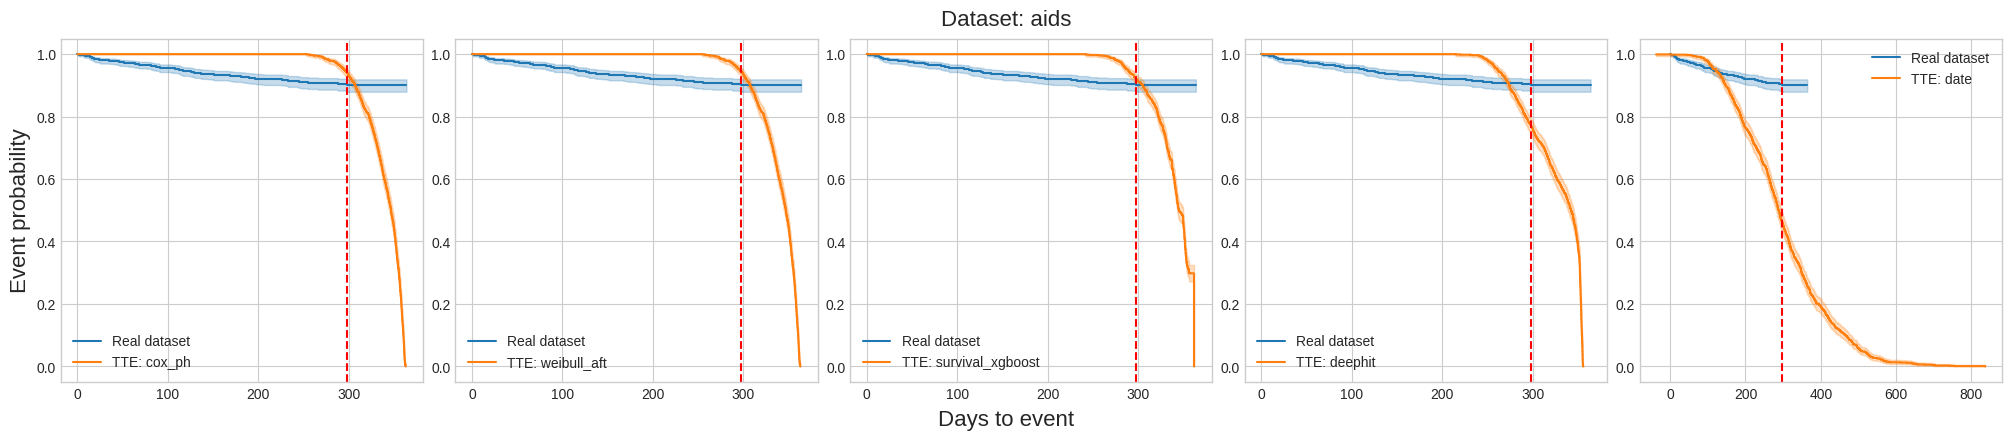

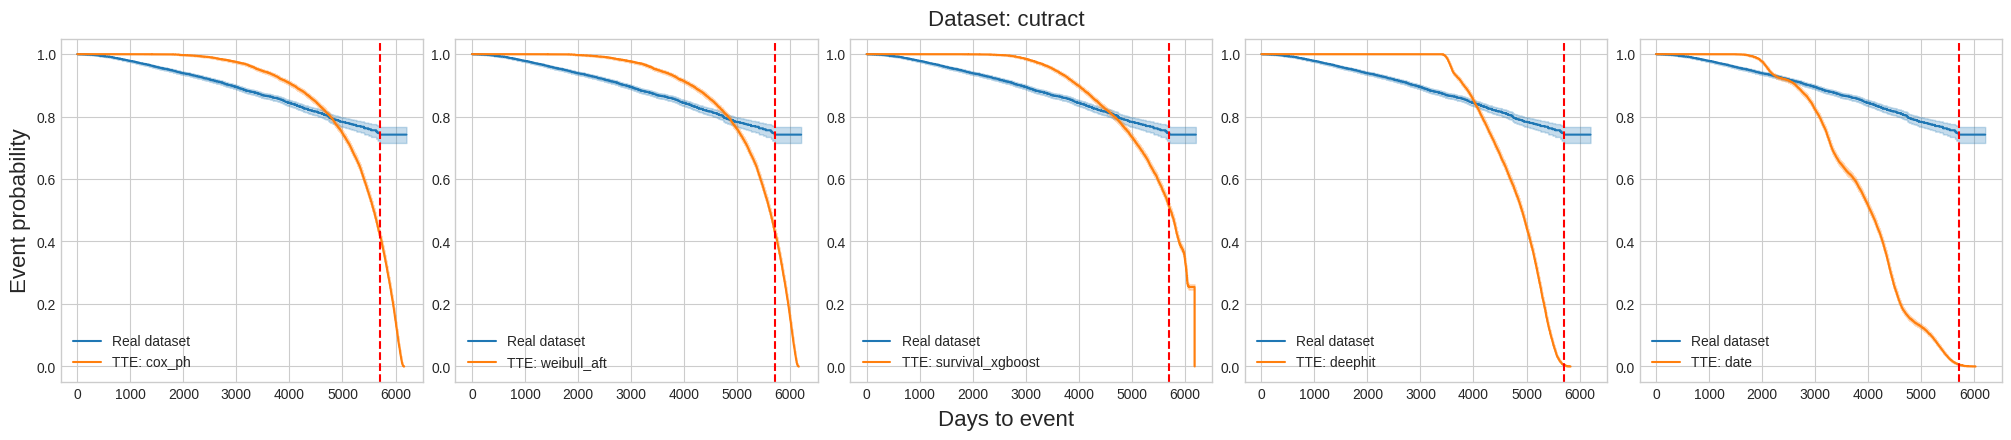

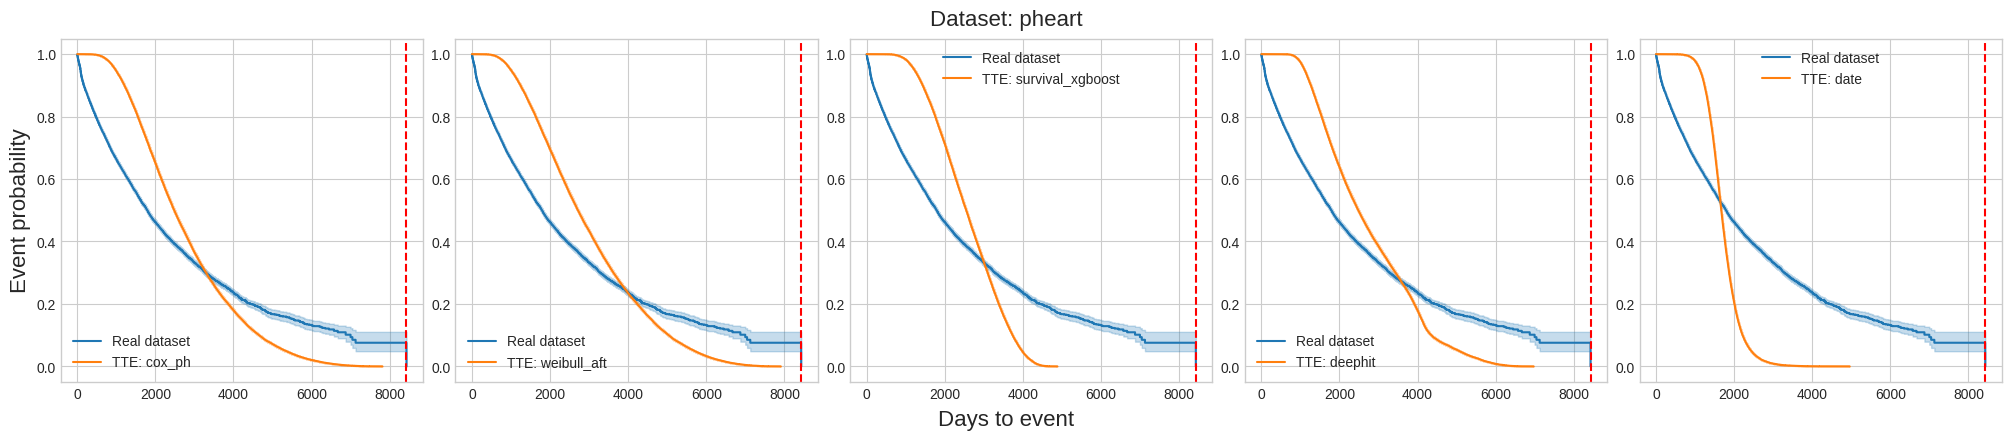

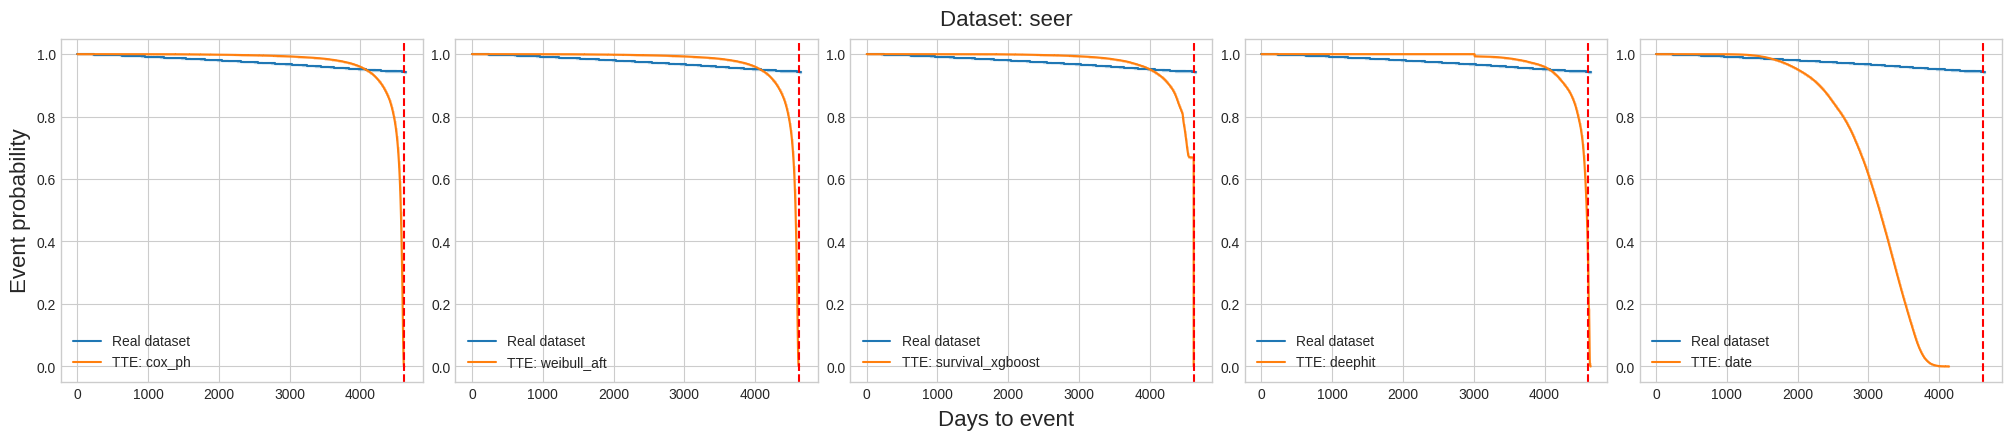

In [6]:
for dataset in ["aids", "cutract", "maggic", "seer"]:
    models = []
    for n in tte_models:
        models.append(get_model_template(n)())
    real_dataset = dataset
    df, duration_col, event_col, time_horizons = get_dataset(real_dataset)

    Xcov = df.drop(columns=[duration_col, event_col])
    T = df[duration_col]
    E = df[event_col]

    plot_tte(real_dataset, Xcov, T, E, models)